In [1]:
from pathlib import Path
import copy
from tqdm import tqdm 

import torch
import pyscf
import numpy as np
import opt_einsum as oe

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol


/home/dhem/anaconda3/envs/pyscf/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
molecular = copy.deepcopy(Mol["Methane"])
molecular[0][1] += 0.0

dft2cc = CC_DFT_DATA(
    molecular,
    name="test",
    basis="cc-pvdz",
    if_basis_str=True,
)

mf = pyscf.scf.RHF(dft2cc.mol)
mf.kernel()
mycc = pyscf.cc.CCSD(mf)
mycc.kernel()
dm1_cc = mycc.make_rdm1(ao_repr=True)
dm2_cc = mycc.make_rdm2(ao_repr=True)
e_cc = mycc.e_tot

mdft = pyscf.scf.RKS(dft2cc.mol)
mdft.xc = "b3lyp"
mdft.kernel()
e_dft = mdft.e_tot
dm1_dft = mdft.make_rdm1(ao_repr=True)

grids = Grid(dft2cc.mol)
coords = grids.coords
weights = grids.weights
ao_2 = pyscf.dft.numint.eval_ao(dft2cc.mol, coords, deriv=2)
ao_0 = ao_2[0, :, :]
ao_value = ao_2[:4, :, :]
ao_2_diag = ao_2[4, :, :] + ao_2[7, :, :] + ao_2[9, :, :]

rho_dft = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_dft, xctype="GGA")
rho_cc = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_cc, xctype="GGA")

rho_dft_grids = grids.vector_to_matrix(rho_dft[0])
rho_cc_grids = grids.vector_to_matrix(rho_cc[0])

In [3]:
exc_over_dm_cc_grids = np.zeros_like(rho_dft[0])
exc_over_dm_cc_grids = -pyscf.dft.libxc.eval_xc("b3lyp", rho_dft)[0] * rho_dft[0]
expr_rinv_dm2_r = oe.contract_expression(
    "ijkl,i,j,kl->",
    0.5 * (dm2_cc - oe.contract("pq,rs->pqrs", dm1_dft, dm1_dft))
    + 0.05 * oe.contract("pr,qs->pqrs", dm1_dft, dm1_dft),
    (dft2cc.mol.nao,),
    (dft2cc.mol.nao,),
    (dft2cc.mol.nao, dft2cc.mol.nao),
    constants=[0],
    optimize="optimal",
)

for i, coord in enumerate(tqdm(coords)):
    ao_0_i = ao_value[0][i]
    if np.linalg.norm(ao_0_i) < 1e-10:
        continue
    with dft2cc.mol.with_rinv_origin(coord):
        rinv = dft2cc.mol.intor("int1e_rinv")
        exc_over_dm_cc_grids[i] += expr_rinv_dm2_r(ao_0_i, ao_0_i, rinv)

    for i_atom in range(dft2cc.mol.natm):
        exc_over_dm_cc_grids[i] -= (
            (rho_cc[0][i] - rho_dft[0][i])
            * dft2cc.mol.atom_charges()[i_atom]
            / np.linalg.norm(dft2cc.mol.atom_coords()[i_atom] - coord)
        )

dm1_cc_mo = mycc.make_rdm1(ao_repr=False)
eigs_e_dm1, eigs_v_dm1 = np.linalg.eigh(dm1_cc_mo)
eigs_v_dm1 = mf.mo_coeff @ eigs_v_dm1
for i in range(np.shape(eigs_v_dm1)[1]):
    part = oe.contract(
        "pm,m,n,pn->p",
        ao_0,
        eigs_v_dm1[:, i],
        eigs_v_dm1[:, i],
        ao_2_diag,
    )
    exc_over_dm_cc_grids += -part * eigs_e_dm1[i] / 2

for i in range(dft2cc.mol.nelec[0]):
    part = oe.contract(
        "pm,m,n,pn->p",
        ao_0,
        mdft.mo_coeff[:, i],
        mdft.mo_coeff[:, i],
        ao_2_diag,
    )
    exc_over_dm_cc_grids += part

error = np.sum(exc_over_dm_cc_grids * weights) - (e_cc - e_dft)

print(f"Error: {(1e3 * error):.5f} mHa")

100%|██████████| 113250/113250 [00:58<00:00, 1925.94it/s]


Error: 0.00013 mHa


In [9]:
ene_cc_grids = grids.vector_to_matrix(exc_over_dm_cc_grids)
rho_cc_grids_pred = np.zeros_like(rho_cc_grids)
ene_cc_grids_pred = np.zeros_like(rho_cc_grids)

In [23]:
from cadft.utils import ModelDict

Modeldict = ModelDict(302, 3, 1, "cuda")
Modeldict.load_model("2024-06-07-12-53-06")

RuntimeError: Error(s) in loading state_dict for UNet:
	Missing key(s) in state_dict: "model.decoder.blocks.x_0_0.conv1.1.weight", "model.decoder.blocks.x_0_0.conv1.1.bias", "model.decoder.blocks.x_0_0.conv1.1.running_mean", "model.decoder.blocks.x_0_0.conv1.1.running_var", "model.decoder.blocks.x_0_0.conv2.1.weight", "model.decoder.blocks.x_0_0.conv2.1.bias", "model.decoder.blocks.x_0_0.conv2.1.running_mean", "model.decoder.blocks.x_0_0.conv2.1.running_var", "model.decoder.blocks.x_0_1.conv1.1.weight", "model.decoder.blocks.x_0_1.conv1.1.bias", "model.decoder.blocks.x_0_1.conv1.1.running_mean", "model.decoder.blocks.x_0_1.conv1.1.running_var", "model.decoder.blocks.x_0_1.conv2.1.weight", "model.decoder.blocks.x_0_1.conv2.1.bias", "model.decoder.blocks.x_0_1.conv2.1.running_mean", "model.decoder.blocks.x_0_1.conv2.1.running_var", "model.decoder.blocks.x_1_1.conv1.1.weight", "model.decoder.blocks.x_1_1.conv1.1.bias", "model.decoder.blocks.x_1_1.conv1.1.running_mean", "model.decoder.blocks.x_1_1.conv1.1.running_var", "model.decoder.blocks.x_1_1.conv2.1.weight", "model.decoder.blocks.x_1_1.conv2.1.bias", "model.decoder.blocks.x_1_1.conv2.1.running_mean", "model.decoder.blocks.x_1_1.conv2.1.running_var", "model.decoder.blocks.x_0_2.conv1.1.weight", "model.decoder.blocks.x_0_2.conv1.1.bias", "model.decoder.blocks.x_0_2.conv1.1.running_mean", "model.decoder.blocks.x_0_2.conv1.1.running_var", "model.decoder.blocks.x_0_2.conv2.1.weight", "model.decoder.blocks.x_0_2.conv2.1.bias", "model.decoder.blocks.x_0_2.conv2.1.running_mean", "model.decoder.blocks.x_0_2.conv2.1.running_var". 
	Unexpected key(s) in state_dict: "model.decoder.blocks.x_0_0.conv1.0.bias", "model.decoder.blocks.x_0_0.conv2.0.bias", "model.decoder.blocks.x_0_1.conv1.0.bias", "model.decoder.blocks.x_0_1.conv2.0.bias", "model.decoder.blocks.x_1_1.conv1.0.bias", "model.decoder.blocks.x_1_1.conv2.0.bias", "model.decoder.blocks.x_0_2.conv1.0.bias", "model.decoder.blocks.x_0_2.conv2.0.bias". 

In [20]:
weight = grids.vector_to_matrix(weights)
input_i_tmp = rho_dft_grids[:, 6:-5, :][:, np.newaxis, :, :]
input_i = np.zeros_like(input_i_tmp)

input_i[0] = input_i_tmp[1]
input_i[1] = input_i_tmp[3]
input_i[2] = input_i_tmp[4]
input_i[3] = input_i_tmp[0]
input_i[4] = input_i_tmp[2]

weight_i = weight[:, 6:-5, :][:, np.newaxis, :, :]

input_gpu = torch.tensor(input_i, dtype=torch.float64).to("cuda")
output_ = Modeldict.model_dict["1"](input_gpu).detach().cpu().numpy()
# print(output_)
rho_cc_grids_pred[:, 6:-5, :] = np.squeeze(output_ / 1000 + input_i, axis=1)
output_ = Modeldict.model_dict["2"](input_gpu).detach().cpu().numpy()
ene_cc_grids_pred[:, 6:-5, :] = np.squeeze(output_ / 1000, axis=1)

print(np.sum(grids.matrix_to_vector(ene_cc_grids_pred) * weights) - (e_cc - e_dft))
# print(ene_)

0.030328443158430557


In [21]:
print(
    np.sum(
        np.abs(
            grids.matrix_to_vector(ene_cc_grids_pred) * weights
            - grids.matrix_to_vector(ene_cc_grids) * weights
        )
    )
)

print(np.sum(np.abs(grids.matrix_to_vector(ene_cc_grids) * weights)))

print(
    np.sum(
        grids.matrix_to_vector(ene_cc_grids_pred) * weights
        - grids.matrix_to_vector(ene_cc_grids) * weights
    )
)

0.4449777562211158
0.36705452042958275
0.030328315413492988


(-2.5, 2.5)

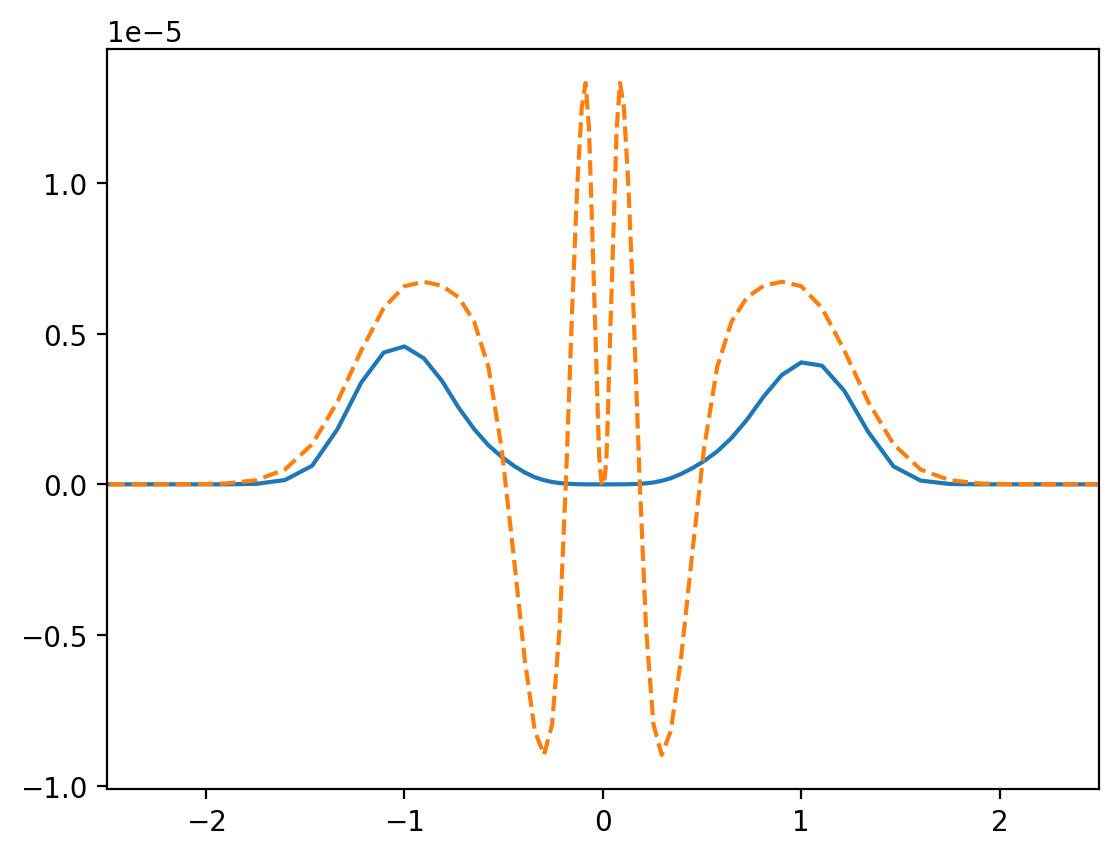

In [22]:
index_ = np.where((np.abs(coords[:, 1]) < 1e-14) & (np.abs(coords[:, 2]) < 1e-14))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y1 = (grids.matrix_to_vector(ene_cc_grids_pred) * weights)[index_][sort_]
y2 = (grids.matrix_to_vector(ene_cc_grids) * weights)[index_][sort_]

plt.plot(x, y1, label="Predicted")
plt.plot(x, y2, label="Exact", linestyle="--")
plt.xlim(-2.5, 2.5)

In [10]:
x = grids.vector_to_matrix(grids.coords[:, 0])[0, 0, :]
y = grids.vector_to_matrix(grids.coords[:, 1])[0, 0, :]
z = grids.vector_to_matrix(grids.coords[:, 2])[0, 0, :]

z.shape

(302,)

In [26]:
# print(
#     np.sum((grids.matrix_to_vector(rho_cc_grids_pred - rho_cc_grids) * weights))
# )
# print(np.sum((grids.matrix_to_vector(rho_dft_grids - rho_cc_grids) * weights)))

print(np.sum((rho_dft_grids * grids.vector_to_matrix(weights))))
print(np.sum((ene_cc_grids * grids.vector_to_matrix(weights))))

index_1 = np.mean(np.abs(rho_cc_grids), axis=-1) > 1e-5
index_2 = np.mean(np.abs(rho_cc_grids * grids.vector_to_matrix(weights)), axis=-1)> 1e-8
index_ = np.logical_not(index_1 & index_2)
print(np.where(index_))
print(np.sum((rho_dft_grids * grids.vector_to_matrix(weights))[index_]))
print(np.sum((ene_cc_grids * grids.vector_to_matrix(weights))[index_]))

index_ = index_1 & index_2
print(np.sum((rho_dft_grids * grids.vector_to_matrix(weights))[index_]))
print(np.sum((ene_cc_grids * grids.vector_to_matrix(weights))[index_]))
# print(np.sum((grids.matrix_to_vector(rho_dft_grids - rho_cc_grids) * weights)))

9.999999596299151
0.1479665564661628
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]), array([ 0,  1,  2,  3,  4,  5,  6,  7, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       11, 12, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74,  0,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 11, 12, 13, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 62, 63, 64,
      

In [81]:
ene_cc_grids[:,6:-5,:].shape
np.array(range(20)), np.array(range(20))[6:-5]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([ 6,  7,  8,  9, 10, 11, 12, 13, 14]))

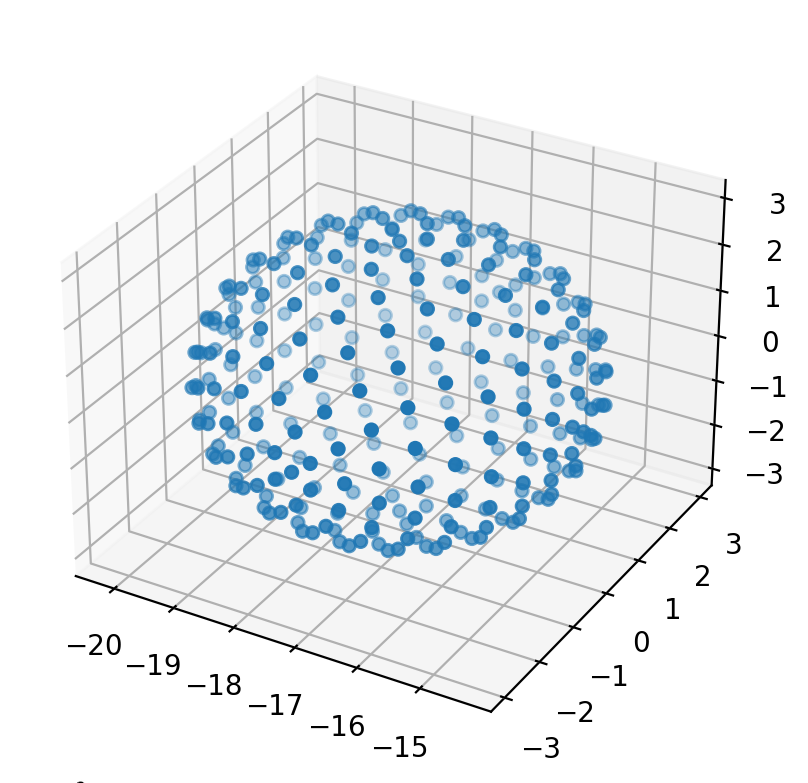

In [20]:
# polt x, y, z
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z)